In [11]:
import numpy               as np
import matplotlib.pyplot   as pp
import pandas              as pd
import seaborn             as sb

from sklearn               import metrics
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.mixture       import GaussianMixture

from matplotlib.colors     import LogNorm

from IPython.display       import HTML, Markdown

## Helper Functions

In [12]:
def color(text, color = 'red', background = 'transparent', weight = 'normal') :
    return f'<span style="color:{color};background:{background};font-weight:{weight}">{text}</span>'

def mark(*objects, sep = ' ') :
    return display(Markdown(sep.join(str(o) for o in objects)))

def line(header = '') :
    
    return mark('<hr/>')

mark('<b>hi</b>', [1,2,3], color('hello world', weight = 'bold'), color('!!!', weight = 'bold', background = 'black'))
line()

<b>hi</b> [1, 2, 3] <span style="color:red;background:transparent;font-weight:bold">hello world</span> <span style="color:red;background:black;font-weight:bold">!!!</span>

<hr/>

## Exploratory Data Analysis

In [35]:
train        = pd.read_csv('input/train.csv', parse_dates=['first_active_month']).set_index('card_id')
test         = pd.read_csv('input/test.csv',  parse_dates=['first_active_month']).set_index('card_id')
merchants    = pd.read_csv('input/merchants.csv').set_index('merchant_id')
#transactions = pd.read_csv('../input/historical_transactions.csv')
#submission   = pd.read_csv('../input/sample_submission.csv')

In [30]:
mark('<b>Code Book for Training Data</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'train', header = 2).style.hide_index())
line()

mark('<b>Code Book for Historical Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'history', header = 2).style.hide_index())
line()

mark('<b>Code Book for New Merchant Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'new_merchant_period', header = 2).style.hide_index())
line()

mark('<b>Code Book for Merchant Details</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'merchant', header = 2).style.hide_index())

<b>Code Book for Training Data</b>

Columns,Description
card_id,Unique card identifier
first_active_month,"'YYYY-MM', month of first purchase"
feature_1,Anonymized card categorical feature
feature_2,Anonymized card categorical feature
feature_3,Anonymized card categorical feature
target,Loyalty numerical score calculated 2 months after historical and evaluation period


<hr/>

<b>Code Book for Historical Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for New Merchant Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for Merchant Details</b>

Columns,Description
merchant_id,Unique merchant identifier
merchant_group_id,Merchant group (anonymized )
merchant_category_id,Unique identifier for merchant category (anonymized )
subsector_id,Merchant category group (anonymized )
numerical_1,anonymized measure
numerical_2,anonymized measure
category_1,anonymized category
most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E
most_recent_purchases_range,Range of quantity of transactions in last active month --> A > B > C > D > E
avg_sales_lag3,Monthly average of revenue in last 3 months divided by revenue in last active month


In [36]:
train.head()

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820283
C_ID_3d0044924f,2017-01-01,4,1,0,0.392913
C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056
C_ID_186d6a6901,2017-09-01,4,3,0,0.142495
C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749


In [39]:
train.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


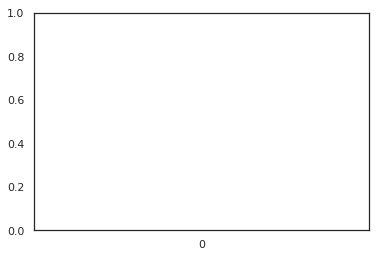

In [34]:
sb.set(style='white', context='notebook', palette='deep')
sb.violinplot()

Text(0, 0.5, 'Loyalty Score')

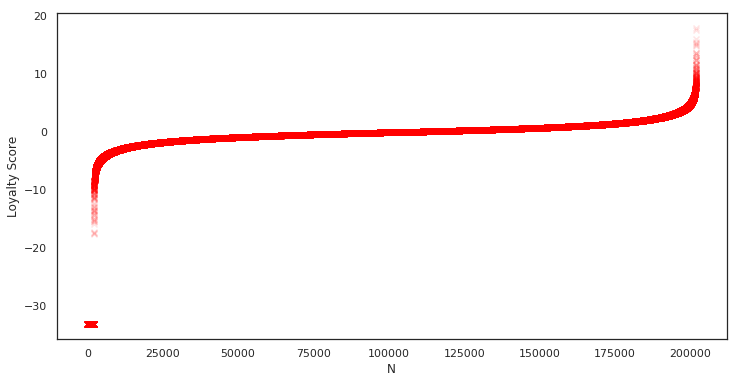

In [68]:
pp.figure(figsize = (12,6))
pp.scatter(range(train.shape[0]), np.sort(train['target'].values), marker = 'x', c = 'red', alpha = .1)
pp.xlabel('N')
pp.ylabel('Loyalty Score')

Text(0.5, 1.0, 'Scatter of the Loyalty Score')

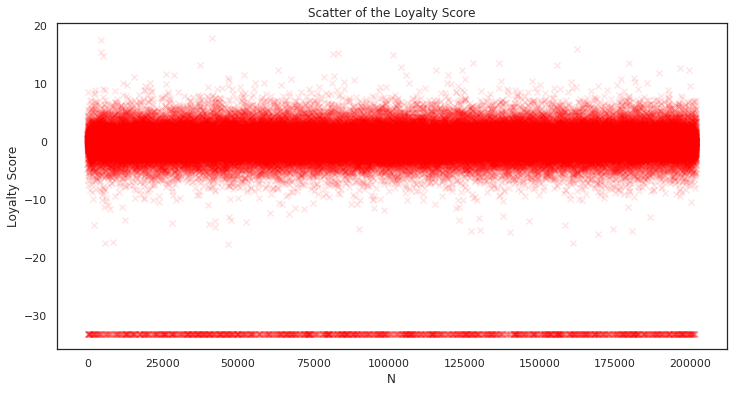

In [70]:
pp.figure(figsize = (12,6))
pp.scatter(range(train.shape[0]), train['target'], marker = 'x', c = 'red', alpha = .1)
pp.xlabel('N')
pp.ylabel('Loyalty Score')
pp.title('Scatter of the Loyalty Score')

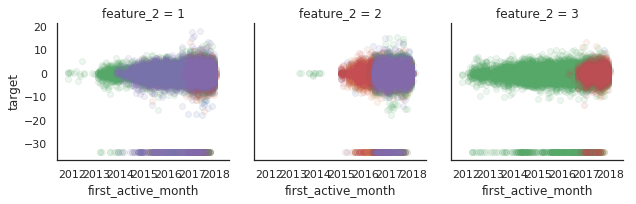

In [107]:
grid = sb.FacetGrid(train, hue = 'feature_1', col = 'feature_2')
grid = grid.map(pp.scatter, 'first_active_month', 'target', alpha = .1)

In [55]:
train['year' ] = train['first_active_month'].dt.year
train['month'] = train['first_active_month'].dt.month

In [93]:
fam_min   = train['first_active_month'].min()
fam_max   = train['first_active_month'].max()
fam_range = 12 * (fam_max.year - fam_min.year) + (fam_max.month - fam_min.month)

print(fam_range)


train['months'] = train['first_active_month'].apply(lambda d : ((d.year - min_fam.year) * 12 + (d.month - min_fam.month))/fam_range)

print((max_fam - min_fam).days)

print()


75
2284



In [109]:
pd.get_dummies(train, columns = ['feature_1', 'feature_2', 'feature_3']).drop(['first_active_month'], axis = 1)

,target,year,month,months,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1
card_id,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,2017,6,0.893333,0,0,0,0,1,0,1,0,0,1
C_ID_3d0044924f,0.392913,2017,1,0.826667,0,0,0,1,0,1,0,0,1,0
C_ID_d639edf6cd,0.688056,2016,8,0.760000,0,1,0,0,0,0,1,0,1,0
C_ID_186d6a6901,0.142495,2017,9,0.933333,0,0,0,1,0,0,0,1,1,0
C_ID_cdbd2c0db2,-0.159749,2017,11,0.960000,1,0,0,0,0,0,0,1,1,0
C_ID_0894217f2f,0.871585,2016,9,0.773333,0,0,0,1,0,0,1,0,1,0
C_ID_7e63323c00,0.230129,2016,12,0.813333,0,0,1,0,0,0,1,0,0,1
C_ID_dfa21fc124,2.135850,2017,9,0.933333,0,0,1,0,0,0,1,0,0,1
C_ID_fe0fdac8ea,-0.065406,2017,8,0.920000,0,1,0,0,0,1,0,0,1,0


In [79]:
pd.get_dummies(train, columns = ['feature_1', 'feature_2', 'feature_3'], drop_first = True)

,first_active_month,target,year,month,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
card_id,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,-0.820283,2017,6,0,0,0,1,1,0,1
C_ID_3d0044924f,2017-01-01,0.392913,2017,1,0,0,1,0,0,0,0
C_ID_d639edf6cd,2016-08-01,0.688056,2016,8,1,0,0,0,1,0,0
C_ID_186d6a6901,2017-09-01,0.142495,2017,9,0,0,1,0,0,1,0
C_ID_cdbd2c0db2,2017-11-01,-0.159749,2017,11,0,0,0,0,0,1,0
C_ID_0894217f2f,2016-09-01,0.871585,2016,9,0,0,1,0,1,0,0
C_ID_7e63323c00,2016-12-01,0.230129,2016,12,0,1,0,0,1,0,1
C_ID_dfa21fc124,2017-09-01,2.135850,2017,9,0,1,0,0,1,0,1
C_ID_fe0fdac8ea,2017-08-01,-0.065406,2017,8,1,0,0,0,0,0,0
